# 22차시: 모델 성능 평가 (MSE, R-squared, Confusion Matrix)

## 학습 목표
- 회귀 모델 평가 지표 (MSE, RMSE, R2)의 **의미** 이해
- 분류 모델 평가 지표 (Accuracy, Precision, Recall)의 **차이** 이해
- **금융 상황에 맞는 지표 선택** 방법 학습

## 학습 내용
1. 왜 평가 지표가 중요한가?
2. 회귀 평가 지표: R2와 RMSE
3. 분류 평가 지표: Precision vs Recall
4. Confusion Matrix 이해
5. 금융에서의 지표 선택

## 중요 주의사항 (Warning)

본 교재와 실습에서 사용하는 모든 데이터, 모델, 기법은
오직 머신러닝 개념 이해와 교육 목적을 위한 예제입니다. 따라서,
실제 금융 시장의 복잡성, 리스크, 거래 비용, 정책·심리 요인 등을 전혀 반영하지 못하며, 실제 투자 판단이나 매매 전략에 사용해서는 안 됩니다.

실습 결과는 "참고용·학습용"으로만 활용하시기 바랍니다.

In [1]:
!pip install -Uq pykrx koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 9.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from IPython.display import display

---
## 1. 왜 평가 지표가 중요한가?

### 모델이 "좋다"는 것을 어떻게 판단할까?

- 20차시에서 만든 회귀 모델의 R2가 0.85라면 좋은 건가요?
- 21차시에서 만든 분류 모델의 Accuracy가 60%라면 좋은 건가요?

### 평가 지표 선택이 중요한 이유

| 상황 | 잘못된 선택 | 결과 |
|------|-------------|------|
| 불균형 데이터 | Accuracy만 봄 | 성능 과대평가 |
| 매수 신호 예측 | Recall만 봄 | 잘못된 매수 증가 |
| 부도 예측 | Precision만 봄 | 실제 부도 놓침 |

**결론: 상황에 맞는 지표 선택이 필수!**

---
## 2. 회귀 평가 지표: R2와 RMSE

20차시에서 배운 회귀 모델을 복습하며 지표의 **의미**를 깊이 이해합니다.

### 주요 지표
| 지표 | 의미 | 해석 |
|------|------|------|
| R2 | 모델이 데이터를 얼마나 잘 설명하는가 | 0~1, 높을수록 좋음 |
| RMSE | 평균적으로 얼마나 틀리는가 | 원래 단위(원), 낮을수록 좋음 |

In [3]:
from pykrx import stock
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 삼성전자 데이터 수집 (20차시와 동일)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
start_str = start_date.strftime('%Y%m%d')
end_str = end_date.strftime('%Y%m%d')

print("[데이터 수집 - 삼성전자]")
df = stock.get_market_ohlcv(start_str, end_str, "005930")
print(f"수집된 데이터: {len(df)}개")

# 특성 생성 (20차시와 동일)
df['전일종가'] = df['종가'].shift(1)
df['수익률'] = df['종가'].pct_change() * 100
df['5일이동평균'] = df['종가'].rolling(5).mean()
df['거래량비율'] = df['거래량'] / df['거래량'].rolling(20).mean()
df['다음날종가'] = df['종가'].shift(-1)
df = df.dropna()

[데이터 수집 - 삼성전자]
수집된 데이터: 243개


In [4]:
# 회귀 모델 학습 (20차시 복습)
feature_cols = ['전일종가', '수익률', '5일이동평균', '거래량비율']
X = df[feature_cols]
y = df['다음날종가']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_reg = LinearRegression()
model_reg.fit(X_train_scaled, y_train)
y_pred_reg = model_reg.predict(X_test_scaled)

In [5]:
# 회귀 평가 지표 계산
r2 = r2_score(y_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))

print("[회귀 모델 평가 지표]")
print("=" * 50)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:,.0f}원")

[회귀 모델 평가 지표]
R2 Score: 0.7494
RMSE: 3,341원


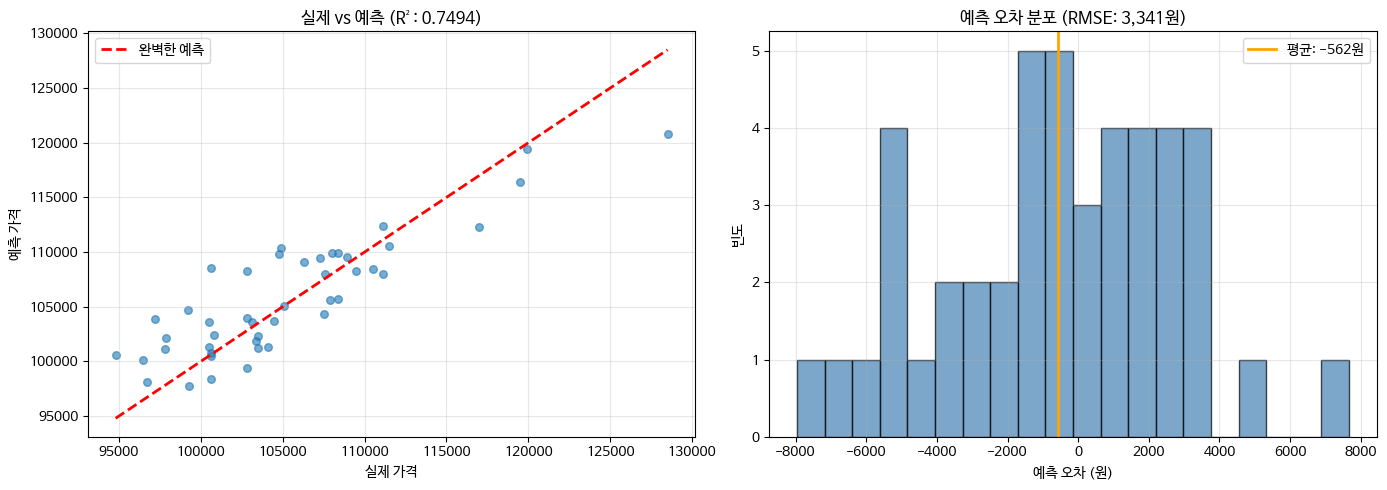


RMSE 3,341원의 의미:
→ 평균적으로 실제 주가와 3,341원 정도 차이남
→ 현재 주가 119,900원 대비 약 2.8% 오차


In [6]:
# 회귀 모델 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 실제 vs 예측
axes[0].scatter(y_test, y_pred_reg, alpha=0.6, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='완벽한 예측')
axes[0].set_xlabel('실제 가격')
axes[0].set_ylabel('예측 가격')
axes[0].set_title(f'실제 vs 예측 (R²: {r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 오차 분포
errors = y_test.values - y_pred_reg
axes[1].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(errors.mean(), color='orange', linestyle='-', linewidth=2, label=f'평균: {errors.mean():,.0f}원')
axes[1].set_xlabel('예측 오차 (원)')
axes[1].set_ylabel('빈도')
axes[1].set_title(f'예측 오차 분포 (RMSE: {rmse:,.0f}원)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRMSE {rmse:,.0f}원의 의미:")
print(f"→ 평균적으로 실제 주가와 {rmse:,.0f}원 정도 차이남")
print(f"→ 현재 주가 {df['종가'].iloc[-1]:,}원 대비 약 {rmse/df['종가'].iloc[-1]*100:.1f}% 오차")

---
## 3. 분류 평가 지표: Precision vs Recall

21차시에서 배운 분류 모델을 복습하며 **Precision과 Recall의 차이**를 이해합니다.

### 핵심 개념
| 지표 | 질문 | 수식 |
|------|------|------|
| **Accuracy** | 전체 중 맞춘 비율은? | (TP + TN) / 전체 |
| **Precision** | 상승 예측 중 실제로 상승한 비율은? | TP / (TP + FP) |
| **Recall** | 실제 상승 중 예측한 비율은? | TP / (TP + FN) |

### 용어 정리
- **TP (True Positive)**: 상승 예측 → 실제 상승 (정답!)
- **FP (False Positive)**: 상승 예측 → 실제 하락 (잘못된 매수 신호)
- **FN (False Negative)**: 하락 예측 → 실제 상승 (기회 놓침)
- **TN (True Negative)**: 하락 예측 → 실제 하락 (정답!)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 분류 모델용 타겟 생성 (21차시와 동일)
df_cls = df.copy()
df_cls['다음날상승'] = (df_cls['다음날종가'] > df_cls['종가']).astype(int)

X_cls = df_cls[feature_cols]
y_cls = df_cls['다음날상승']

X_train_cls, X_test_cls = X_cls[:split_idx], X_cls[split_idx:]
y_train_cls, y_test_cls = y_cls[:split_idx], y_cls[split_idx:]

X_train_cls_scaled = scaler.fit_transform(X_train_cls)
X_test_cls_scaled = scaler.transform(X_test_cls)

model_cls = LogisticRegression(random_state=42, max_iter=1000)
model_cls.fit(X_train_cls_scaled, y_train_cls)
y_pred_cls = model_cls.predict(X_test_cls_scaled)

In [8]:
# 분류 평가 지표 계산
accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls, zero_division=0)
recall = recall_score(y_test_cls, y_pred_cls, zero_division=0)

print("[분류 모델 평가 지표]")
print("=" * 50)
print(f"Accuracy:  {accuracy:.1%} (전체 중 맞춘 비율)")
print(f"Precision: {precision:.1%} (상승 예측 중 실제 상승)")
print(f"Recall:    {recall:.1%} (실제 상승 중 예측 상승)")

[분류 모델 평가 지표]
Accuracy:  57.8% (전체 중 맞춘 비율)
Precision: 57.8% (상승 예측 중 실제 상승)
Recall:    100.0% (실제 상승 중 예측 상승)


In [9]:
# Precision vs Recall 이해
print("\n[Precision vs Recall 비교]")
print("=" * 50)

print("""
Precision이 높다 = 상승이라고 예측하면 대부분 맞음
                 → "신중한 예측" (확실할 때만 상승 예측)

Recall이 높다 = 실제 상승을 놓치지 않고 잘 잡아냄
              → "적극적인 예측" (상승 기회를 놓치지 않음)

[트레이드오프]
- Precision을 높이면 → Recall이 낮아지는 경향
- Recall을 높이면 → Precision이 낮아지는 경향
- 상황에 따라 어느 쪽이 더 중요한지 판단 필요!
""")


[Precision vs Recall 비교]

Precision이 높다 = 상승이라고 예측하면 대부분 맞음
                 → "신중한 예측" (확실할 때만 상승 예측)

Recall이 높다 = 실제 상승을 놓치지 않고 잘 잡아냄
              → "적극적인 예측" (상승 기회를 놓치지 않음)

[트레이드오프]
- Precision을 높이면 → Recall이 낮아지는 경향
- Recall을 높이면 → Precision이 낮아지는 경향
- 상황에 따라 어느 쪽이 더 중요한지 판단 필요!



---
## 4. Confusion Matrix 이해

Confusion Matrix에서 각 지표가 어떻게 계산되는지 직접 확인합니다.

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix 계산
cm = confusion_matrix(y_test_cls, y_pred_cls)

print("[Confusion Matrix]")
print("=" * 50)
print(cm)
print()

TN, FP, FN, TP = cm.ravel()
print(f"TN (하락→하락): {TN} - 정확한 하락 예측")
print(f"FP (하락→상승): {FP} - 잘못된 상승 예측 (거짓 양성)")
print(f"FN (상승→하락): {FN} - 놓친 상승 (거짓 음성)")
print(f"TP (상승→상승): {TP} - 정확한 상승 예측")

[Confusion Matrix]
[[ 0 19]
 [ 0 26]]

TN (하락→하락): 0 - 정확한 하락 예측
FP (하락→상승): 19 - 잘못된 상승 예측 (거짓 양성)
FN (상승→하락): 0 - 놓친 상승 (거짓 음성)
TP (상승→상승): 26 - 정확한 상승 예측


In [11]:
# 직접 계산 확인
print("\n[Confusion Matrix에서 지표 계산]")
print("=" * 50)

accuracy_manual = (TP + TN) / (TP + TN + FP + FN)
precision_manual = TP / (TP + FP) if (TP + FP) > 0 else 0
recall_manual = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Accuracy  = (TP + TN) / 전체 = ({TP} + {TN}) / {TP+TN+FP+FN} = {accuracy_manual:.1%}")
print(f"Precision = TP / (TP + FP) = {TP} / ({TP} + {FP}) = {precision_manual:.1%}")
print(f"Recall    = TP / (TP + FN) = {TP} / ({TP} + {FN}) = {recall_manual:.1%}")


[Confusion Matrix에서 지표 계산]
Accuracy  = (TP + TN) / 전체 = (26 + 0) / 45 = 57.8%
Precision = TP / (TP + FP) = 26 / (26 + 19) = 57.8%
Recall    = TP / (TP + FN) = 26 / (26 + 0) = 100.0%


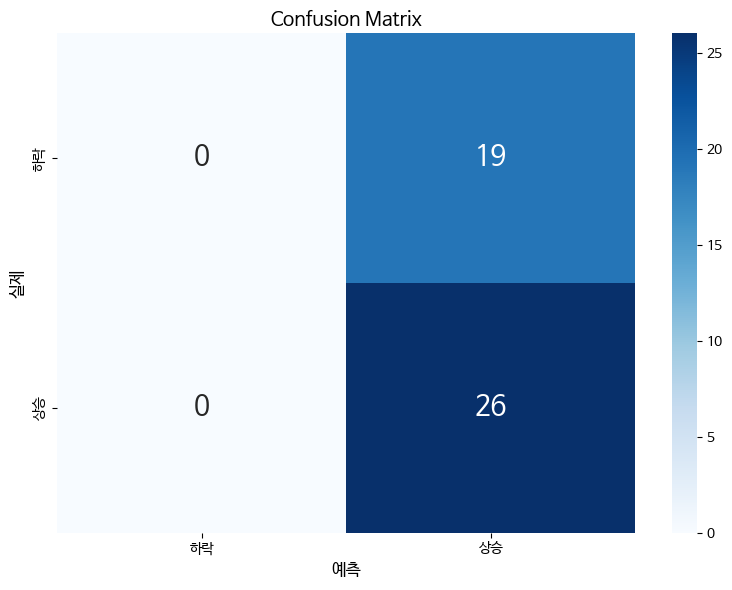

In [12]:
# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['하락', '상승'], yticklabels=['하락', '상승'],
            annot_kws={'size': 20})
plt.xlabel('예측', fontsize=12)
plt.ylabel('실제', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
# Confusion Matrix 결과 해석
print("\n[Confusion Matrix 결과 해석]")
print("=" * 50)

# 예측 분포 확인
pred_down = TN + FN  # 하락으로 예측한 수
pred_up = FP + TP    # 상승으로 예측한 수

print(f"하락 예측: {pred_down}건")
print(f"상승 예측: {pred_up}건")
print()

if pred_down == 0:
    print("[주의] 모델이 모든 데이터를 '상승'으로 예측했습니다!")
    print()
    print("이 경우:")
    print(f"  - Recall = {TP}/{TP+FN} = 100% (당연히 높음)")
    print(f"  - 하지만 이건 '항상 상승이라고 찍는 것'과 동일")
    print(f"  - 실제 상승 비율({(TP+FN)/(TP+TN+FP+FN):.1%})과 Accuracy가 비슷")
    print()
    print("→ Recall이 높다고 좋은 모델이 아닙니다!")
    print("→ Confusion Matrix를 반드시 확인해야 합니다!")
elif pred_up == 0:
    print("[주의] 모델이 모든 데이터를 '하락'으로 예측했습니다!")
else:
    print("모델이 상승/하락을 모두 예측하고 있습니다.")


[Confusion Matrix 결과 해석]
하락 예측: 0건
상승 예측: 45건

[주의] 모델이 모든 데이터를 '상승'으로 예측했습니다!

이 경우:
  - Recall = 26/26 = 100% (당연히 높음)
  - 하지만 이건 '항상 상승이라고 찍는 것'과 동일
  - 실제 상승 비율(57.8%)과 Accuracy가 비슷

→ Recall이 높다고 좋은 모델이 아닙니다!
→ Confusion Matrix를 반드시 확인해야 합니다!


---
## 5. 금융에서의 지표 선택

### 상황별 중요 지표

| 상황 | 중요 지표 | 이유 |
|------|-----------|------|
| **매수 신호 예측** | Precision | FP(잘못된 매수)가 비용 발생 |
| **부도 예측** | Recall | FN(부도 놓침)이 큰 손실 |
| **전반적 성능** | Accuracy | 데이터가 균형일 때만 |

In [14]:
print("[금융에서 지표 선택 가이드]")
print("=" * 60)
print()
print("1. 매수 신호 예측 (Precision 중요)")
print("   - 상승 예측이 틀리면? → 손실 발생 (매수했는데 하락)")
print("   - Precision 높게: 확실할 때만 매수 신호")
print()
print("2. 리스크 관리/부도 예측 (Recall 중요)")
print("   - 부도를 놓치면? → 큰 손실")
print("   - Recall 높게: 위험 신호를 놓치지 않음")
print()
print("3. 일반적인 예측 (Accuracy)")
print("   - 데이터가 균형일 때 사용")
print("   - 불균형 데이터에서는 성능 과대평가 주의!")

[금융에서 지표 선택 가이드]

1. 매수 신호 예측 (Precision 중요)
   - 상승 예측이 틀리면? → 손실 발생 (매수했는데 하락)
   - Precision 높게: 확실할 때만 매수 신호

2. 리스크 관리/부도 예측 (Recall 중요)
   - 부도를 놓치면? → 큰 손실
   - Recall 높게: 위험 신호를 놓치지 않음

3. 일반적인 예측 (Accuracy)
   - 데이터가 균형일 때 사용
   - 불균형 데이터에서는 성능 과대평가 주의!


In [15]:
# 현재 모델 평가 요약
print("\n[현재 모델 평가 요약]")
print("=" * 60)
print()
print("[ 회귀 모델 (다음날 주가 예측) ]")
print(f"  R2:   {r2:.4f} → 변동성의 {r2*100:.1f}% 설명")
print(f"  RMSE: {rmse:,.0f}원 → 평균 {rmse:,.0f}원 오차")
print()
print("[ 분류 모델 (다음날 상승/하락 예측) ]")
print(f"  Accuracy:  {accuracy:.1%} → 전체 정확도")
print(f"  Precision: {precision:.1%} → 상승 예측 신뢰도")
print(f"  Recall:    {recall:.1%} → 상승 포착률")
print()

if accuracy > 0.5:
    print("→ 분류 모델이 랜덤(50%)보다 나은 성능을 보임")
else:
    print("→ 분류 모델이 랜덤(50%)보다 낮음, 개선 필요")


[현재 모델 평가 요약]

[ 회귀 모델 (다음날 주가 예측) ]
  R2:   0.7494 → 변동성의 74.9% 설명
  RMSE: 3,341원 → 평균 3,341원 오차

[ 분류 모델 (다음날 상승/하락 예측) ]
  Accuracy:  57.8% → 전체 정확도
  Precision: 57.8% → 상승 예측 신뢰도
  Recall:    100.0% → 상승 포착률

→ 분류 모델이 랜덤(50%)보다 나은 성능을 보임


---
## 학습 정리

### 1. 회귀 평가 지표
| 지표 | 의미 | 좋은 값 |
|------|------|---------|
| R2 | 설명력 | 1에 가까울수록 |
| RMSE | 평균 오차 | 작을수록 |

### 2. 분류 평가 지표
| 지표 | 의미 | 언제 중요? |
|------|------|-----------|
| Accuracy | 전체 정확도 | 균형 데이터 |
| Precision | 예측 신뢰도 | 잘못된 매수 방지 |
| Recall | 포착률 | 기회 놓치지 않기 |

### 3. 핵심 코드
```python
# 회귀
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 분류
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()
```

---

### 다음 차시 예고
- 23차시: 딥러닝 기초 - LSTM 이해하기
  - RNN과 LSTM의 원리
  - 시계열 예측에 특화된 구조
  - TensorFlow/Keras 기초